In [1]:
from src.pipeline import build_pipeline

departure = 'LEMD'
destinations = [
  'LEAS',
  'LEBB',
  'LEBL',
  'LECO',
  'LEGR',
  'LEJR'
]

flights_path = 'data/flights'
flights_points_path = 'data/flight_points'

data_pipeline = build_pipeline(flights_path = flights_path, 
                               flights_points_path = flights_points_path, 
                               departure = departure, 
                               destinations = destinations)

trajectories_result, sspd_calculator, erp_calculator = data_pipeline.transform(None)

trajectories = trajectories_result['trajectories']
sspd_distances = sspd_calculator['sspd_distances']
erp_distances = erp_calculator['erp_distances']

## SSPD distances

### DBSCAN

In order to determine the best value of eps for your dataset, use the K-Nearest Neighbours approach as explained in these two papers: [Sander et al. 1998](https://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.63.1629&rep=rep1&type=pdf) and [Schubert et al. 2017](https://www.ccs.neu.edu/home/vip/teach/DMcourse/2_cluster_EM_mixt/notes_slides/revisitofrevisitDBSCAN.pdf) (both papers from the original DBSCAN authors).

(1400.0, 1800.0, 0.0, 0.1)

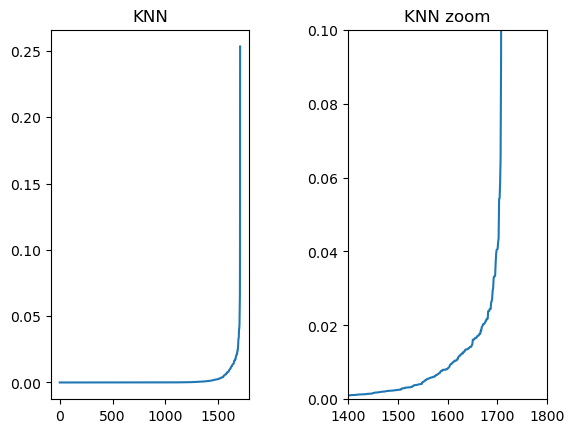

In [2]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(sspd_distances)
distances, indices = neighbors_fit.kneighbors(sspd_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title('KNN')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('KNN zoom')
plt.axis([1400, 1800, 0, 0.1])

In [3]:
import pandas as pd
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(sspd_distances, params = {
  "eps": np.arange(0.01, 0.1, 0.005),
  "min_samples": np.arange(3, 16)
}, method="davies_bouldin")

print(pd.DataFrame(search["results_"]).head(20))

                                              params  clusters  outliers   
0                   {'eps': 0.015, 'min_samples': 3}        32        79  \
1                    {'eps': 0.01, 'min_samples': 5}        28       154   
2                    {'eps': 0.01, 'min_samples': 4}        30       145   
3    {'eps': 0.019999999999999997, 'min_samples': 8}        12       103   
4    {'eps': 0.019999999999999997, 'min_samples': 9}        12       105   
5   {'eps': 0.019999999999999997, 'min_samples': 10}        11       115   
6    {'eps': 0.019999999999999997, 'min_samples': 7}        13        95   
7    {'eps': 0.019999999999999997, 'min_samples': 6}        13        92   
8    {'eps': 0.019999999999999997, 'min_samples': 5}        15        78   
9                    {'eps': 0.01, 'min_samples': 3}        35       129   
10                   {'eps': 0.01, 'min_samples': 6}        24       178   
11  {'eps': 0.019999999999999997, 'min_samples': 11}        11       118   
12          

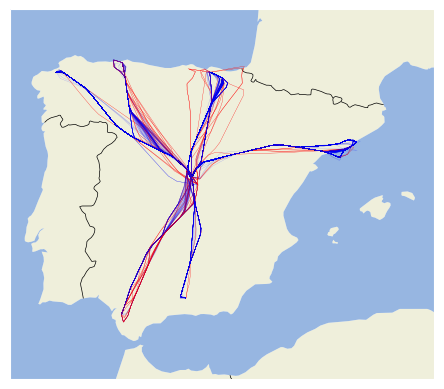

In [4]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

# Run the grid search
params = search["best_estimator_"]["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(sspd_distances)
labels = clusterer.labels_

show_outliers_map(trajectories, clusterer.labels_, 'results/graphs/trajectories/outliers_sspd_dbscan.png')

### HDBSCAN

In [10]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(sspd_distances, params = { 
    "min_samples": np.arange(1, 16),
    "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
}, method="davies_bouldin")

print(pd.DataFrame(search["results_"]).head(20))

                                         params  clusters  outliers   
0    {'min_samples': 13, 'min_cluster_size': 2}        59       472  \
1    {'min_samples': 1, 'min_cluster_size': 40}        15       275   
2    {'min_samples': 2, 'min_cluster_size': 40}        15       281   
3    {'min_samples': 3, 'min_cluster_size': 40}        15       272   
4    {'min_samples': 14, 'min_cluster_size': 2}        43       400   
5     {'min_samples': 9, 'min_cluster_size': 2}        78       513   
6    {'min_samples': 12, 'min_cluster_size': 2}        62       503   
7     {'min_samples': 1, 'min_cluster_size': 2}       478       237   
8     {'min_samples': 8, 'min_cluster_size': 2}        87       531   
9     {'min_samples': 5, 'min_cluster_size': 2}       107       452   
10   {'min_samples': 6, 'min_cluster_size': 20}        22       301   
11    {'min_samples': 2, 'min_cluster_size': 2}       249       331   
12   {'min_samples': 11, 'min_cluster_size': 2}        69       526   
13   {

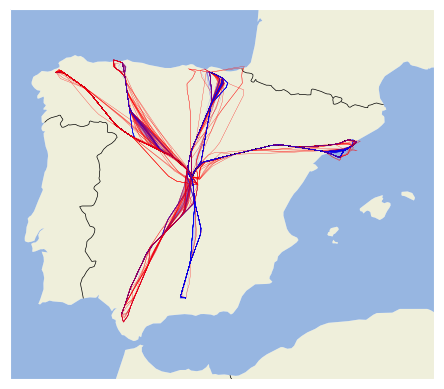

In [11]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(sspd_distances)

show_outliers_map(trajectories, clusterer.labels_, 'results/graphs/trajectories/outliers_sspd_hdbscan.png')

## ERP Distances

### DBSCAN

(1000.0, 1800.0, 0.0, 100000.0)

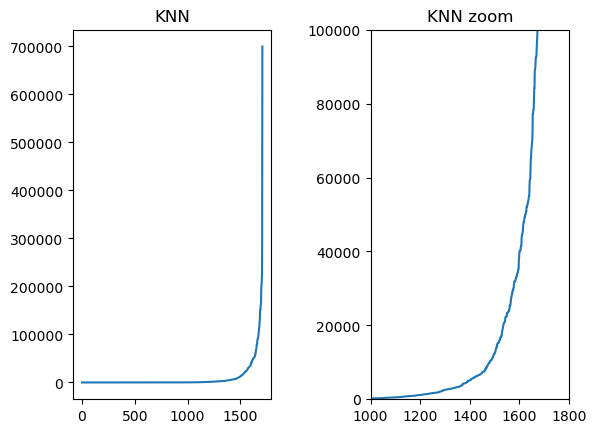

In [24]:
from sklearn.neighbors import NearestNeighbors
from matplotlib import pyplot as plt
import numpy as np

neighbors = NearestNeighbors(n_neighbors=6, metric='precomputed')
neighbors_fit = neighbors.fit(erp_distances)
distances, indices = neighbors_fit.kneighbors(erp_distances)

distances = np.sort(distances, axis=0)
distances = distances[:,1]

plt.subplot(1, 2, 1)
plt.plot(distances)
plt.title('KNN')
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 2, 2)
plt.plot(distances)
plt.title('KNN zoom')
plt.axis([1000, 1800, 0, 100000])

In [15]:
from src.models.search_dbscan import SearchDBSCAN

search = SearchDBSCAN(erp_distances, params = {
  "eps": np.arange(50000, 220000, 5000),
  "min_samples": np.arange(1, 5)
}, method="davies_bouldin")

print(pd.DataFrame(search["results_"]).head(20))

                               params  clusters  outliers     noise   
0   {'eps': 190000, 'min_samples': 2}        18        12  0.701754  \
1   {'eps': 195000, 'min_samples': 2}        18        12  0.701754   
2   {'eps': 200000, 'min_samples': 2}        18        10  0.584795   
3   {'eps': 180000, 'min_samples': 2}        19        12  0.701754   
4   {'eps': 185000, 'min_samples': 2}        19        12  0.701754   
5   {'eps': 140000, 'min_samples': 3}        15        36  2.105263   
6   {'eps': 215000, 'min_samples': 3}        13        13  0.760234   
7   {'eps': 175000, 'min_samples': 2}        20        12  0.701754   
8   {'eps': 145000, 'min_samples': 3}        14        34  1.988304   
9   {'eps': 150000, 'min_samples': 3}        14        34  1.988304   
10  {'eps': 170000, 'min_samples': 2}        20        13  0.760234   
11  {'eps': 140000, 'min_samples': 2}        21        24  1.403509   
12  {'eps': 190000, 'min_samples': 3}        13        22  1.286550   
13  {'

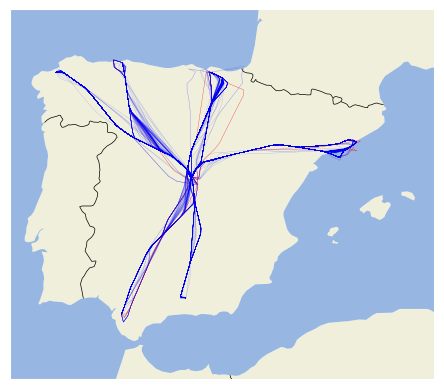

In [16]:
from utils.graphs import show_outliers_map
from sklearn.cluster import DBSCAN

params = search["best_estimator_"]["params"]
clusterer = DBSCAN(metric='precomputed', 
                   min_samples=params["min_samples"], 
                   eps=params["eps"])
clusterer.fit(erp_distances)

show_outliers_map(trajectories, clusterer.labels_, 'results/graphs/trajectories/outliers_erp_dbscan.png')

### HDBSCAN

In [19]:
from src.models.search_hdbscan import SearchHDBSCAN

search = SearchHDBSCAN(sspd_distances, params = {
  "min_samples": np.arange(1, 16),
  "min_cluster_size": np.array([2, 5, 10, 20, 40, 60, 80, 100, 120, 140])
}, method="davies_bouldin")

print(pd.DataFrame(search["results_"]).head(20))

                                         params  clusters  outliers   
0    {'min_samples': 13, 'min_cluster_size': 2}        59       472  \
1    {'min_samples': 1, 'min_cluster_size': 40}        15       275   
2    {'min_samples': 2, 'min_cluster_size': 40}        15       281   
3    {'min_samples': 3, 'min_cluster_size': 40}        15       272   
4    {'min_samples': 14, 'min_cluster_size': 2}        43       400   
5     {'min_samples': 9, 'min_cluster_size': 2}        78       513   
6    {'min_samples': 12, 'min_cluster_size': 2}        62       503   
7     {'min_samples': 1, 'min_cluster_size': 2}       478       237   
8     {'min_samples': 8, 'min_cluster_size': 2}        87       531   
9     {'min_samples': 5, 'min_cluster_size': 2}       107       452   
10   {'min_samples': 6, 'min_cluster_size': 20}        22       301   
11    {'min_samples': 2, 'min_cluster_size': 2}       249       331   
12   {'min_samples': 11, 'min_cluster_size': 2}        69       526   
13   {

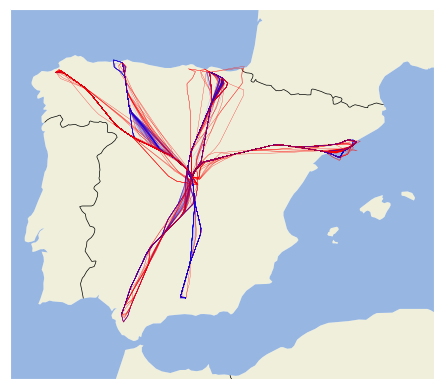

In [20]:
from utils.graphs import show_outliers_map
import hdbscan

params = search["best_estimator_"]["params"]
clusterer = hdbscan.HDBSCAN(metric='precomputed', 
                            min_samples=params["min_samples"], 
                            min_cluster_size =params["min_cluster_size"])
clusterer.fit(erp_distances)


show_outliers_map(trajectories, clusterer.labels_, 'results/graphs/trajectories/outliers_erp_hdbscan.png')